# Introduction: PyTorchInspector, Lenses and Visualizers

## Abstract
In this notebook we will introduce ``PyTorchInspector`` class, a gate to monitorch, lens classes, that are responsible for data collection and preprocessing, and visualizers. We will teach several networks for classification on tabular dataset.

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import datasets
from sklearn.model_selection import train_test_split

RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

We will train our neural net on [UCI ML Wine Data Set](https://archive.ics.uci.edu/dataset/109/wine). Our task is to show librairy's functionality, thus we will treat all 13 numerical features as being anonymized, we also will not create test set to check our model, as there is no need for that. Nevertheless, we will display five samples from the dataset to see how a row might look.

In [2]:
wine_dataset = datasets.load_wine()

Xtrain, Xval, ytrain, yval = train_test_split(
    wine_dataset['data'], wine_dataset['target'],
    random_state=RND_SEED, shuffle=True, test_size=0.2
)

BATCH_SIZE = 8
train_dataloader = DataLoader(
    TensorDataset(
        torch.from_numpy(Xtrain).float(), torch.from_numpy(ytrain).long()
    ),
    shuffle=True, batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    TensorDataset(
        torch.from_numpy(Xval).float(), torch.from_numpy(yval).long()
    ),
    shuffle=True, batch_size=BATCH_SIZE
)

pd.DataFrame(
    np.concat([wine_dataset['data'], wine_dataset['target'].reshape(-1, 1)], axis=1)
).sample(5, random_state=RND_SEED).rename(columns={i:f'X{i}' for i in range(13)}).rename(columns={13:'target'})

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,target
19,13.64,3.10,2.56,15.2,116.0,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845.0,0.0
45,14.21,4.04,2.44,18.9,111.0,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080.0,0.0
140,12.93,2.81,2.70,21.0,96.0,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600.0,2.0
30,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0.0
67,12.37,1.17,1.92,19.6,78.0,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510.0,1.0


## Neural Net Definition

We will define a simple neural net for our task, it will include three hidden layers with ReLU activations and a softmax output. We will allow a custom probability dropout between the second and the third layers. We will also define functions to train and validate one epoch.

In [3]:
from collections import OrderedDict

class SimpleMLP(nn.Module):

    def __init__(self, dropout_p=0):
        super().__init__()
        self.net = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(13, 32)),
            ('relu1', nn.ReLU()),

            ('lin2', nn.Linear(32, 32)),
            ('relu2', nn.ReLU()),

            ('dropout', nn.Dropout(dropout_p)),
            ('lin3', nn.Linear(32, 16)),
            ('relu3', nn.ReLU()),
            
            ('lin4', nn.Linear(16, 3)),
            ('softmax', nn.Softmax(dim=1)),
        ]))

    def forward(self, X):
        return self.net(X)

    @torch.no_grad
    def predict(self, X):
        return self.net(X).argmax(dim=1)

def train_one_epoch(model, loss_fn, optimizer, train_dataloader=train_dataloader):
    """ Trains model through dataset one time. Returns mean loss accross batches. """
    loss_agg = 0
    for data, label in train_dataloader:
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    train_n_samples = train_dataloader.dataset.tensors[0].shape[0]
    return loss_agg / train_n_samples

@torch.no_grad
def validate_one_epoch(model, loss_fn, val_dataloader=val_dataloader):
    """ Validates through given dataset, returns accuracy and mean loss accross batches. """
    correctly_classified = 0
    loss_agg = 0
    for data, label in val_dataloader:
        pred = model(data)
        loss = loss_fn(pred, label)
        correctly_classified += pred.argmax(dim=1).eq(label).float().sum().item()
        loss_agg += loss.item()
    val_n_samples = val_dataloader.dataset.tensors[0].shape[0]
    return correctly_classified / val_n_samples, loss_agg / val_n_samples

## Inspector Definition

Monitorch uses built-in PyTorch hooks to collect training data, classes from ``monitorch.lens`` manage callbacks and data flow, they can be customized using initialization flags to serve your needs. Classes from ``monitorch.visualizer`` are responsible for communication between lenses and visualization libraries such as Matplotlib and TensorBoard. ``PyTorchInspector`` is a class that connects visualizer, lenses and user-defined PyTorch modules. Almost all of the configuration is done through inspector.

To start one needs to provide list of lenses, in this notebook we will use ``LossMetrics``, ``OutputActivation`` and ``ParameterNorm`` lenses; they will be discussed in detail in later notebooks, for our goal it is sufficient to note that ``LossMetrics`` automatically collects loss data, if provided loss function, while ``OutputActivation`` and ``ParameterNorm`` collect per layer data during training.

``PyTorchInspector`` allows to define visualizer from the very start, one can choose any object of concrete subclass of ``AbstractVisualizer``, or provide string ``'matplotlib'``, ``'tensorboard'`` or ``'print'``. Default is ``'matplotlib'``.

``PyTorchInspector`` also collects layers from neural net, use ``depth`` initialization parameter to control what layers should be displayed. Default is to traverse until module does not contain any submodules.

Further inspector configuration can be found at the dedicated documentation page.

In [4]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics, OutputActivation, ParameterGradientGeometry

loss_fn = nn.CrossEntropyLoss()

inspector = PyTorchInspector(
    lenses = [
        LossMetrics(
            loss_fn=loss_fn,
            loss_fn_inplace=False,
            loss_range='Q1-Q3'
        ),
        OutputActivation(),
        ParameterGradientGeometry(compute_adj_prod=False)
    ]
)

## Base Usage

To use predefined inspector, one needs to attach the inspector to the module, then proceed to training as they do usually. At the end of each epoch inspector must be signaled about an end of an epoch using ``tick_epoch()``. That is it! No more additional steps are need to collect data.

Matplotlib visualizer also requires calling ``show_fig()`` to draw plots. Other visualizers draw plots online.

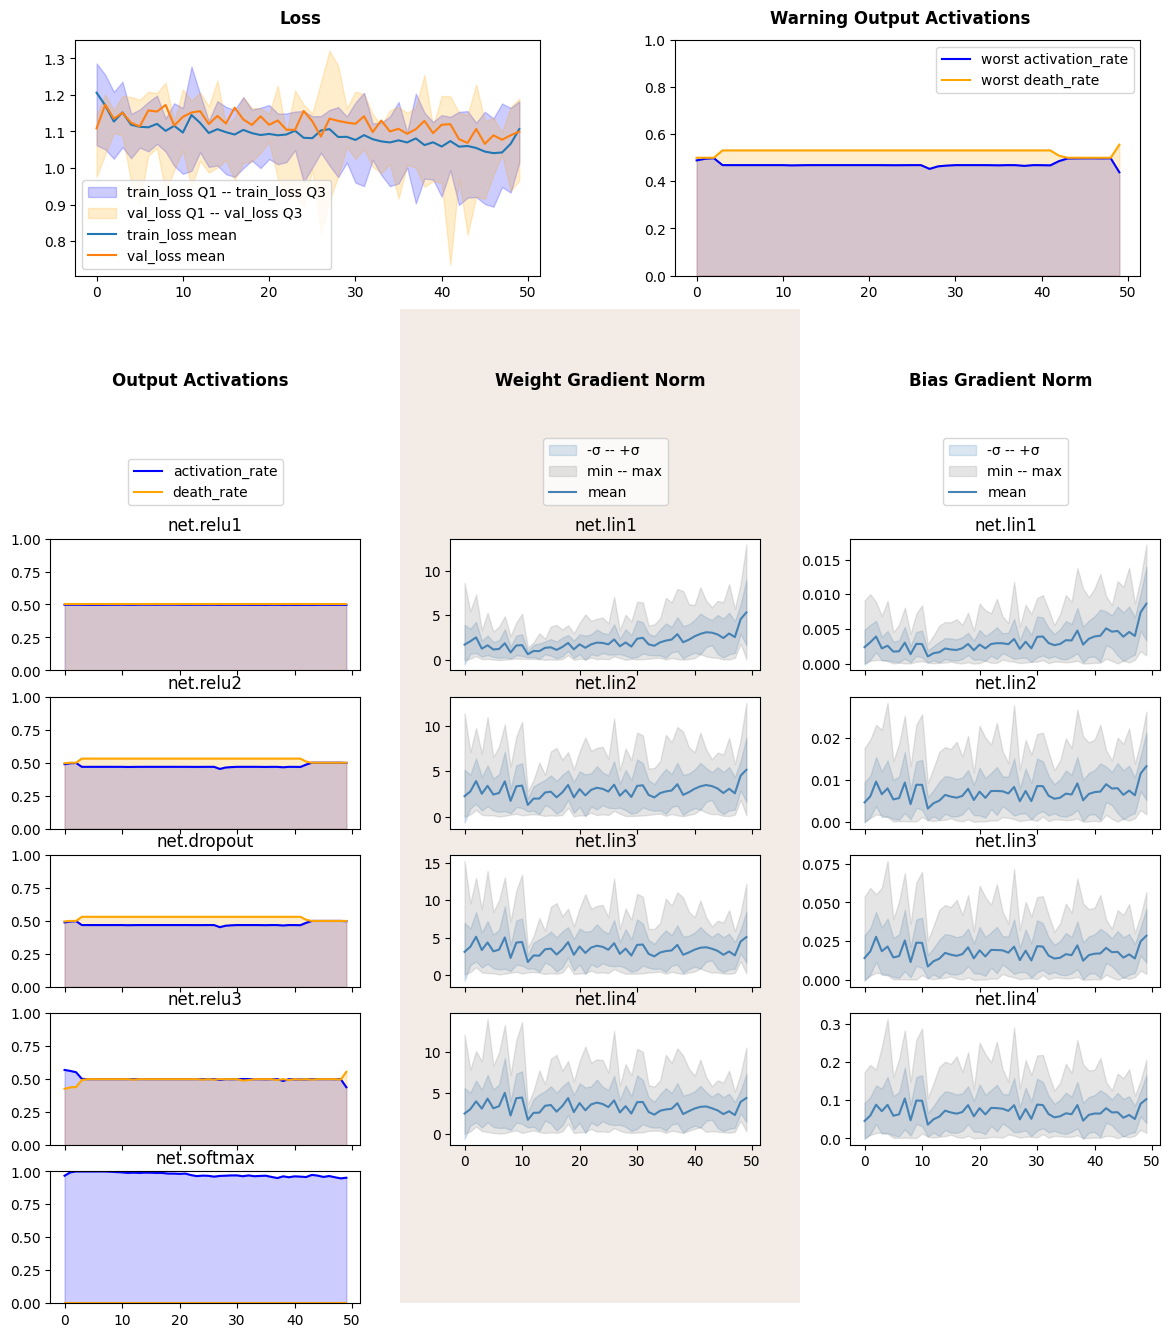

In [5]:
model = SimpleMLP()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)
inspector.attach(model)

N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    train_one_epoch(model, loss_fn, optimizer)
    validate_one_epoch(model, loss_fn)
    inspector.tick_epoch()
fig = inspector.visualizer.show_fig()

## Detach-Attach

One of the main reasons, why we plot data about neural networks, is to compare them between each other. For that ``PyTorchInspector`` is capable to detach and attach to a module, therefore allowing itself to be reused without polluting code with reinitialization.

We will create a new model with destructive dropout and inspect it with the very same object. Pay attention to activation of `net.relu3`.

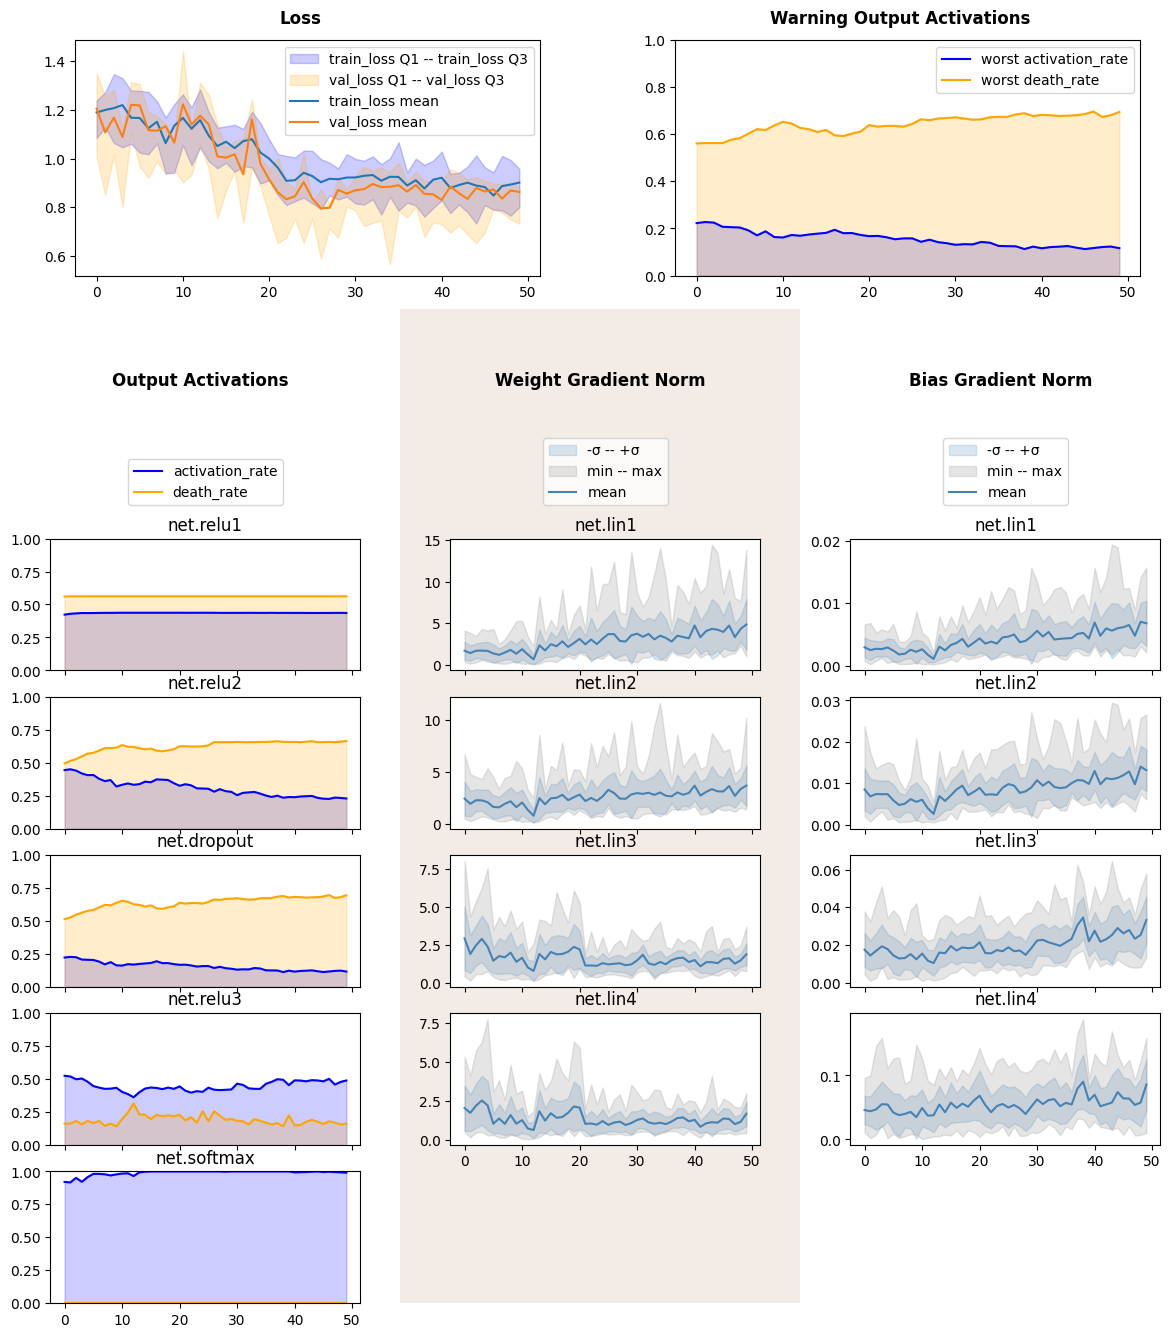

In [6]:
model = SimpleMLP(dropout_p=0.5)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

inspector.attach(model)

N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    train_one_epoch(model, loss_fn, optimizer)
    acc, loss = validate_one_epoch(model, loss_fn)
    inspector.tick_epoch()
fig = inspector.visualizer.show_fig()

We see that death rate was a lot smaller and weight gradient of corresponding linear layer was more stable.

## Hot-Swapping Visualizer

Due to modular structure of ``PyTorchInspector`` visualizer can be replaced by more appropriate tool. To illustrate it we will use ``TensorBoardVisualizer`` on the inspector.

In [7]:
from monitorch.visualizer import TensorBoardVisualizer
inspector.detach().visualizer = TensorBoardVisualizer()

model = SimpleMLP(dropout_p=0.5)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

inspector.attach(model)

N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    train_one_epoch(model, loss_fn, optimizer)
    acc, loss = validate_one_epoch(model, loss_fn)
    inspector.tick_epoch()

Code above will generate data displayable by Tensorboard like a picture below. One could view tensorboard in the notebook using jupyter magics like ``%load_ext`` and ``%tensorboard --logdir='runs'``.

![TensorBoard example](introduction_tensorboard.png "TensorBoard Example")

Be aware that TensorBoard provides much smaller subset of plotting options, than Matplotlib does, so band plots are split into upper and lower bound, while relation plots create new "runs" for every subtag (i.e. layer).

## What Next

* Try monitorch on your favourite dataset.
* Take a look at other demonstration notebooks and documentation.
* Find what lenses expose problem with neural networks that you encounter.